# Using Natural Language Processing to Identify and Predict Clickbait Headlines

In [1]:
#Import necessary packages
from google.colab import files
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn import preprocessing

from gensim.models import Word2Vec

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, MaxPool1D, Dropout, Dense, GlobalMaxPooling1D, Embedding, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
#Here I want to see the list of stopwords included from WordCloud - these are words that will be removed from NLP functions
print(STOPWORDS)

{'no', "wasn't", 'since', 'she', 'there', 'does', 'has', "he's", 'been', "i'll", 'and', 'other', "you'll", 'to', "he'd", 'as', 'your', 'the', "they'll", "here's", 'his', 'my', 'yourselves', 'their', 'such', "hasn't", "who's", "he'll", 'you', "they're", "aren't", 'both', 'herself', 'himself', 'too', 'what', 'against', 'it', 'shall', 'where', 'yourself', "doesn't", 'further', 'like', 'whom', "we're", 'above', 'more', 'cannot', 'were', "why's", "you've", 'hers', 'who', 'ought', "she'd", 'all', 'can', "they've", 'very', 'www', 'into', "can't", 'also', 'if', 'however', "shan't", "didn't", 'some', "let's", 'theirs', 'when', 'k', 'else', "hadn't", 'yours', 'they', 'are', 'these', "won't", 'com', "it's", 'own', 'so', 'ours', "haven't", 'be', 'itself', 'through', 'in', "i've", 'being', 'have', 'between', 'he', 'nor', "how's", "isn't", "shouldn't", 'until', 'with', 'r', 'under', 'of', 'its', 'up', 'which', 'am', "we've", 'during', 'on', 'while', 'her', 'me', 'off', 'or', "mustn't", 'than', 'thos

In [3]:
#Having examined the data, I'm aware of fairly commen use of the letters s and u in the headlines.
#This is a little confusing because I'd assume these would be used in conjunction to refer to the United States of America, 
#but 'US' already exists in the list and is fairly common
STOPWORDS = list(STOPWORDS) + ['s', 'S', 'u', 'U']

In [4]:
# Import the data into a dataframe
uploaded = files.upload()

Saving clickbait_data.csv to clickbait_data (4).csv


In [5]:
ClickBait = pd.read_csv(io.BytesIO(uploaded['clickbait_data.csv']))

In [6]:
#Let's get an overview of the data here
ClickBait.head()

,headline,clickbait
0,Should I Get Bings,1
1,Which TV Female Friend Group Do You Belong In,1
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1
3,"This Vine Of New York On ""Celebrity Big Brothe...",1
4,A Couple Did A Stunning Photo Shoot With Their...,1


In [7]:
ClickBait.dtypes

headline     object
clickbait     int64
dtype: object

## Begin EDA
### OK, so we have two columns here, only the headline and whether or not it's clickbait. I'd like to add a couple more columns to help describe the data.

In [8]:
#Here I'm breaking out all of the headlines into individual words to count
h_d = []
for i in ClickBait['headline']:
    h_d.append(i.split())

print(h_d[:2])

[['Should', 'I', 'Get', 'Bings'], ['Which', 'TV', 'Female', 'Friend', 'Group', 'Do', 'You', 'Belong', 'In']]


In [9]:
#Now we'll calculate how many words in each headline, 
#and we can see if there's a trend of number of words in clickbait vs. not clickbait headlines
length = []
for i in h_d:
    length.append(len(i))
    
print(length[:2])

[4, 9]


In [10]:
#So we have an object - the headline, and a clickbait boolean value, also it looks like our first headline may have a typo
#Next let's create some more summary features to help identify clickbait articles
#First we'll count the total number of words in each headline:
ClickBait['Word Count'] = length

(15999, 16001)


Text(0.5, 1.0, 'Counts of Clickbait and Not Clickbait Headlines')

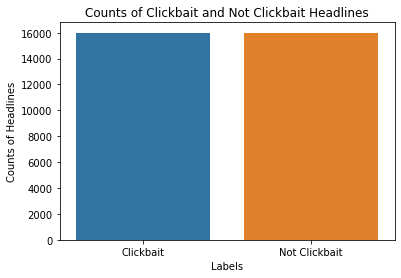

In [11]:
#Let's take a look at some of our data:
#first let's create a new dataframe to visualize our numbers of clickbait and not clickbait headlines
def clickbait_count(x):
    NC = 0
    C = 0
    for y in x:
        if y == 1: 
            C += 1
        else:
            NC += 1
    return(C, NC)
            
counts = clickbait_count(ClickBait['clickbait'])

print(counts)

labels = ['Clickbait', 'Not Clickbait']
values = [15999, 16001]

df = pd.DataFrame({'Labels': labels, 'Count of Headlines': values})

sns.barplot(data = df, x = 'Labels', y = 'Count of Headlines')
plt.ylabel('Counts of Headlines')
plt.title('Counts of Clickbait and Not Clickbait Headlines')

### Wow, almost the same size data sets, that's great! Next lets compute the average length of clickbait and not clickbait headlines

[9.941808863053941, 8.188613211674271] ['Clickbait', 'Not Clickbait']


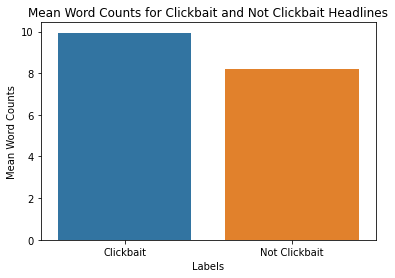

In [12]:
mean_labels = ['Clickbait', 'Not Clickbait']

clickbait_words = ClickBait.loc[ClickBait['clickbait'] == 1]
not_clickbait_words = ClickBait.loc[ClickBait['clickbait'] == 0]
mean_clickbait_words = np.mean(clickbait_words['Word Count'])
mean_not_clickbait_words = np.mean(not_clickbait_words['Word Count'])

mean_counts = [mean_clickbait_words, mean_not_clickbait_words]

print(mean_counts, mean_labels)

mean_words = pd.DataFrame({'Labels': mean_labels, 'Mean Counts': mean_counts})

sns.barplot(data = mean_words, x = 'Labels', y = 'Mean Counts')
plt.ylabel('Mean Word Counts')
plt.title('Mean Word Counts for Clickbait and Not Clickbait Headlines')
plt.show()

### Ok so we have pretty even numbers for set of clickbait types, 15,999 clickbait headlines, and 16,001 not clickbait headlines. Next, let's generate some word clouds of the main words present in each set!

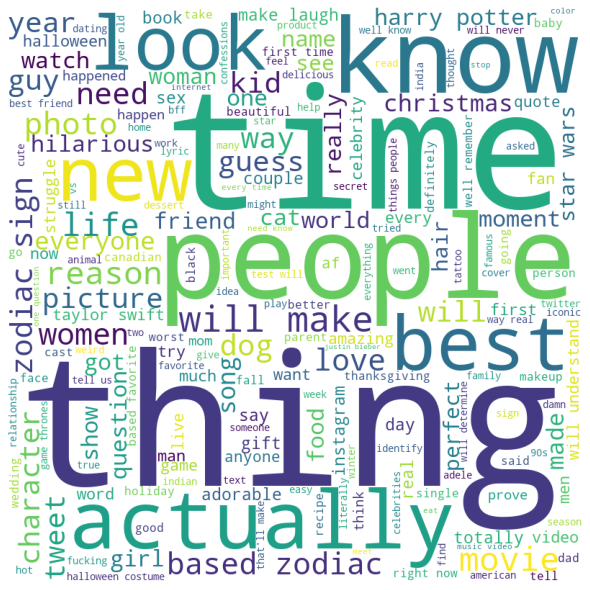

In [13]:
#Clickbait words
comment_words = ''
stopwords = set(STOPWORDS)
  
# iterate through the csv file
for val in clickbait_words.headline:
      
    # typecaste each val to string
    val = str(val)
  
    # split the value
    tokens = val.split()
      
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
  
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

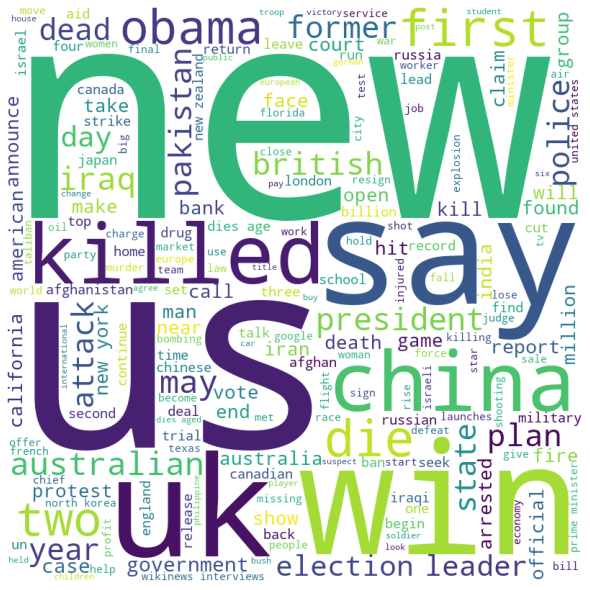

In [14]:
#Not clickbait words
comment_words = ''
stopwords = set(STOPWORDS)
  
# iterate through the csv file
for val in not_clickbait_words.headline:
      
    # typecaste each val to string
    val = str(val)
  
    # split the value
    tokens = val.split()
      
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
  
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

Start building the Model

In [15]:
w2vc_model = Word2Vec(h_d, size=50, workers=32, min_count=1, window=3)
print(w2vc_model)

Word2Vec(vocab=35789, size=50, alpha=0.025)


In [16]:
# tokenize the data

token = Tokenizer(35789)
token.fit_on_texts(ClickBait['headline'])
text = token.texts_to_sequences(ClickBait['headline'])
text = pad_sequences(text)

In [17]:
y = ClickBait['clickbait'].values

In [18]:
# split the data into train test split

X_train, X_test, y_train, y_test = train_test_split(np.array(text), y, test_size=0.2,stratify=y)

In [19]:
# build the model

model = Sequential()
model.add(w2vc_model.wv.get_keras_embedding(True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [20]:
# compile and train model

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=32, validation_data=(X_test, y_test), epochs=3)

Epoch 1/3
800/800 [==============================] - 32s 37ms/step - loss: 0.2528 - accuracy: 0.8920 - val_loss: 0.0775 - val_accuracy: 0.9739
Epoch 2/3
800/800 [==============================] - 30s 37ms/step - loss: 0.0560 - accuracy: 0.9812 - val_loss: 0.0618 - val_accuracy: 0.9786
Epoch 3/3
800/800 [==============================] - 29s 36ms/step - loss: 0.0224 - accuracy: 0.9930 - val_loss: 0.0727 - val_accuracy: 0.9723


<Figure size 432x288 with 0 Axes>

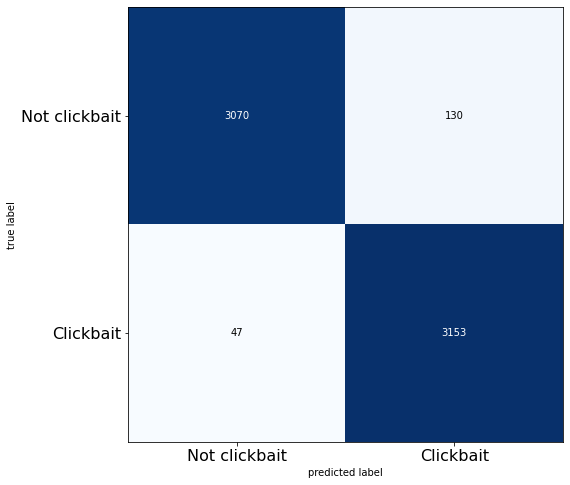

In [21]:
preds = [round(i[0]) for i in model.predict(X_test)]
cm = confusion_matrix(y_test, preds)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Not clickbait', 'Clickbait'], fontsize=16)
plt.yticks(range(2), ['Not clickbait', 'Clickbait'], fontsize=16)
plt.show()

Below is code for downloading and quickly summarizing articles. The idea is to after identifying clickbait headlines you can then create a quick summary of those articles more accurately.Unfortunately it doesn't work with the data set I used here, as I don't have links, only the headlines for the articles.

In [ ]:
from newspaper3k import Article

article = Article(url_link_to_article)

article.download()
article.parse()
article.nlp()

In [ ]:
article.authors #Prints authors of article
article.publish_date #Prints date article was published

In [ ]:
print(article.text) #Prints full text of article

print(article.summary) #Prints summary of article